In [6]:
# Import the required libraries

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddos-sdn-dataset/dataset_sdn.csv


In [8]:
# Perform Data Pre Processing
# Min Max Normalization and Standardization

In [35]:
data = pd.read_csv('/kaggle/input/ddos-sdn-dataset/dataset_sdn.csv')

Y = data['label']
X = data.drop(['label'],axis=1)
X_train, X_test,Y_train, Y_test= train_test_split(X,Y,random_state=104,test_size=0.25,shuffle=True)
train_data = pd.concat([X_train,Y_train], axis=1, join='inner')

correl = train_data.corr()['label'].sort_values()
correl.drop('label',inplace=True)
correl

flows         -0.185567
dt            -0.111862
tot_dur       -0.099997
dur           -0.099984
rx_bytes      -0.058428
Pairflow      -0.052384
tx_bytes      -0.052256
byteperflow   -0.013123
tot_kbps      -0.009120
rx_kbps       -0.008051
tx_kbps       -0.005650
port_no       -0.001832
packetins     -0.001103
switch         0.028410
dur_nsec       0.028749
pktperflow     0.090686
pktrate        0.090881
bytecount      0.277834
pktcount       0.403827
Name: label, dtype: float64

In [ ]:
# Feature Selection

In [13]:
selected = correl.loc[abs(correl)>0.08]
attr_selected = list(selected.index)
print(attr_selected)

norm_x_train_data=(X_train.select_dtypes(include=['float64','int64'])-X_train.min(numeric_only=True))/(X_train.max(numeric_only=True)-X_train.min(numeric_only=True))
norm_x_test_data=(X_test.select_dtypes(include=['float64','int64'])-X_test.min(numeric_only=True))/(X_test.max(numeric_only=True)-X_test.min(numeric_only=True))
norm_x_train_data = preprocessing.scale(norm_x_train_data[attr_selected])
norm_x_test_data = preprocessing.scale(norm_x_test_data[attr_selected])
norm_x_train_data.shape
Y_train.shape

['flows', 'dt', 'tot_dur', 'dur', 'pktperflow', 'pktrate', 'bytecount', 'pktcount']


(78258,)

In [ ]:
# Train the deep learning model

In [10]:
model = keras.Sequential(
[
    layers.Dense(units=1024,activation='relu',input_shape=[len(attr_selected)]),
    layers.Dense(units=1024,activation='relu'),
    layers.Dense(units=1024,activation='relu'),
    layers.Dense(units=1024,activation='relu'),
    layers.Dense(units=1024,activation='relu'),
    layers.Dense(units=1,activation='sigmoid')
    
])
model.compile(
    optimizer = 'Adamax',
    loss = 'mae'
)
earlystop = EarlyStopping(min_delta=0.01,patience=10,restore_best_weights=True)
model.fit(
    x = norm_x_train_data,
    y = Y_train,
    epochs = 50,
    batch_size = 20000,
    callbacks=[earlystop]
)

2022-11-26 04:55:51.318250: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-26 04:55:51.537527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
4/4 [==============================] - 18s 4s/step - loss: 0.4105
Epoch 2/50
4/4 [==============================] - 16s 4s/step - loss: 0.2506
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: 0.1855
Epoch 4/50
4/4 [==============================] - 15s 4s/step - loss: 0.1558
Epoch 5/50
4/4 [==============================] - 16s 4s/step - loss: 0.1286
Epoch 6/50
4/4 [==============================] - 16s 4s/step - loss: 0.1133
Epoch 7/50
4/4 [==============================] - 17s 4s/step - loss: 0.1010
Epoch 8/50
4/4 [==============================] - 16s 4s/step - loss: 0.0949
Epoch 9/50
4/4 [==============================] - 16s 4s/step - loss: 0.0900
Epoch 10/50
4/4 [==============================] - 15s 4s/step - loss: 0.0885
Epoch 11/50
4/4 [==============================] - 17s 4s/step - loss: 0.0868
Epoch 12/50
4/4 [==============================] - 16s 4s/step - loss: 0.0861
Epoch 13/50
4/4 [==============================] - 17s 4s/step - loss: 0.

In [ ]:
# Make the prediction

<AxesSubplot:>

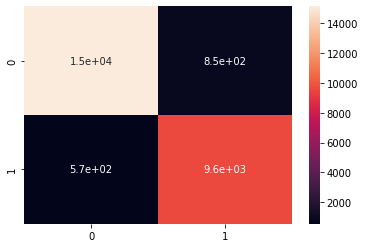

In [25]:
y_pred = pd.Series(model.predict(norm_x_test_data).flatten()).rename('label')
lst = []
for i in y_pred:
    if i>0.5:
        lst.append(1)
    else:
        lst.append(0)
pred = pd.DataFrame(lst)
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True)

In [28]:
print(str(accuracy_score(Y_test, pred)*100)+'%')

94.54900908498486%
